In [142]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn


from matplotlib.font_manager import FontProperties
from shutil import copyfile
from pathlib import Path

from data import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

import sys  
sys.path.insert(0, '../Code')



In [4]:
pd.set_option('display.max_rows', None)

GROUP = 'Group'
GENOME_ID = 'Genome ID'
LABEL = 'Label'

In [5]:
path = Path('..\Data')
test_genome_verified = MetadataReader.read(path / 'test_genomes_verified.csv')
test_genome_verified[LABEL] = test_genome_verified[LABEL].apply(lambda label: GenomesData.label_to_int.get(label))

test_genome_verified.head()

,Genome Name,Label,HP/NHP,species,References,Group,Host Name,Isolation Source,Isolation Comments,Genome Quality,Collection Date,Date Inserted,Other Clinical,Host Health,Disease,Comments
Genome ID,,,,,,,,,,,,,,,,
163603.4,Actinomadura latina strain ATCC BAA-277,1,1/0,Actinomadura latina,\cite{trujillo1997polyphasic},HP,"Human, Homo sapiens",arm of patient,NaN,Good,NaN,2020-04-26 17:38:00.943000+00:00,NaN,NaN,NaN,MicrobeNet genomes
648.157,Aeromonas caviae strain ScAc2001,1,9/0,Aeromonas caviae,\cite{tang2020co},HP,"Human, Homo sapiens",Watery diarrhea,NaN,Good,2019-05,2020-01-31 23:41:12.327000+00:00,NaN,Diarrhea,NaN,Whole genome sequenced and analysis MDR isolat...
565.15,Atlantibacter hermannii strain 3608,1,1/0,Atlantibacter hermannii,\cite{ioannou2019escherichia},HP,"Human, Homo sapiens",Wound swab,NaN,Good,2015,2020-02-07 13:50:54.571000+00:00,NaN,Wound infection 8,NaN,Extended Spectrum beta-lactamase producing Ent...
29459.655,Brucella melitensis strain HN20190002,1,13/0,Brucella melitensis,\cite{li2020molecular},HP,"Human, Homo sapiens",NaN,NaN,Good,2019-02-04,2020-01-31 21:07:14.657000+00:00,NaN,NaN,NaN,"strain was obtained from patients in Hainan,China"
87883.284,Burkholderia multivorans strain C1576,1,107/0,Burkholderia multivorans,\cite{silva2016long},HP,"Human, Homo sapiens",sputum,isolated from a cystic fibrosis patient,Good,1992,2020-03-27 14:33:49.442000+00:00,NaN,Cystic fibrosis,NaN,Whole genome sequencing of a clinical isolate ...


In [6]:
test_genome_verified[GROUP].value_counts()

OHP     77
NHP     61
ONHP    41
HP      25
Name: Group, dtype: int64

In [16]:
def calculate_results_per_group(test_genomes, preds_arr):
    
    results_dict = {}
    
    for group_name, genomes in test_genomes.groupby(GROUP):
        
        y_test_group = test_genomes.loc[genomes.index][LABEL]
        y_pred = preds_arr.loc[genomes.index]['predictions']
        correct = sklearn.metrics.accuracy_score(y_test_group, y_pred, normalize=False)
        accuracy = sklearn.metrics.accuracy_score(y_test_group, y_pred)
        print(f'{group_name}\taccuracy={accuracy:.2f} correctly predicted={correct}/{len(y_test_group)}')
        results_dict[group_name] = accuracy
        
    return results_dict

# bacpacs results

In [17]:
bacpacs_pred_arr = pd.read_csv('bacpacs_prediction_on_newTest14.2.21.csv')  
bacpacs_pred_arr['genome_id'] = bacpacs_pred_arr['genome_id'].str.strip('.PATRIC')
bacpacs_pred_arr = bacpacs_pred_arr.set_index('genome_id') 

In [18]:
print('BacPaCS results:')

bacpacs_results = calculate_results_per_group(test_genome_verified, bacpacs_pred_arr)

BacPaCS results:
HP	accuracy=0.96 correctly predicted=24/25
NHP	accuracy=0.72 correctly predicted=44/61
OHP	accuracy=0.82 correctly predicted=63/77
ONHP	accuracy=0.73 correctly predicted=30/41


# pathogenfinder results

In [19]:
folder = 'results pathogenfinder/'
files = os.listdir(folder)
pathogenfinder_results = pd.DataFrame(index = test_genome_verified.index, columns = ['predictions'], dtype=int)

for name in files:
    if name.startswith('PathogenFinder_cdhit_raw'): continue
        
    genome_id = name.split('.txt', 1)[0].split('_')[2]
    if genome_id in  test_genome_verified.index:
            with open(folder + name , 'r') as input_file:
                for line in input_file: 
                    if line.startswith('The organisms is predicted as human pathogenic ::'):
                        predicted_pathogen = line.strip().split('\t')[1]
                        if predicted_pathogen == 'Yes': pathogenfinder_results.at[genome_id, 'predictions'] = 1
                        elif predicted_pathogen== 'No': pathogenfinder_results.at[genome_id, 'predictions'] = 0
                        else: print(f'Error in results of file: {name}')
                    # Validate that the file name match the input sequence
                    if line.startswith('#input_seq:'):
                        seq_id =  line.split('fig|')[1].split('.peg')[0]
                        if genome_id != seq_id: print(f'Error in file name: {name}')
                        break

In [20]:
print('Pathogenfinder results:')
pathogenfinder_results = calculate_results_per_group(test_genome_verified, pathogenfinder_results)

Pathogenfinder results:
HP	accuracy=0.96 correctly predicted=24/25
NHP	accuracy=0.59 correctly predicted=36/61
OHP	accuracy=0.86 correctly predicted=66/77
ONHP	accuracy=0.29 correctly predicted=12/41


# WSPC results

In [21]:
wspc_preds = pd.read_csv('wspc_test_preds.csv', dtype={GENOME_ID: str}).set_index(GENOME_ID)

In [22]:
wspc_results = calculate_results_per_group(test_genome_verified, wspc_preds)

HP	accuracy=1.00 correctly predicted=25/25
NHP	accuracy=0.93 correctly predicted=57/61
OHP	accuracy=0.92 correctly predicted=71/77
ONHP	accuracy=0.59 correctly predicted=24/41


# Comparative plots

In [195]:
def create_vals_arrs(results_dicts, labels):
    wspc_vals = []; bacpacs_vals = []; pathogenfinder_vals = []; 
    for label in labels:
        pathogenfinder_vals.append(results_dicts['Pathogenfinder'][label])
        bacpacs_vals.append(results_dicts['BacPaCS'][label])
        wspc_vals.append(results_dicts['WSPC'][label])
        
    return wspc_vals, bacpacs_vals, pathogenfinder_vals
    

In [214]:
def label_bars(rects, ax):
    for rect in rects:
        for label in rect:
            height = round(label.get_height(),2)
            ax.annotate('{}'.format(height), xy=(label.get_x() + label.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=14)

In [221]:
def create_comparative_barplots(results_dicts):
    
    labels = results_dicts['WSPC'].keys()
    x = np.arange(len(labels)) 
    width = 0.22
    
    wspc_vals, bacpacs_vals, pathogenfinder_vals = create_vals_arrs(results_dicts, labels)

    fig, ax = plt.subplots(figsize=(14, 6))
    rects1 = ax.bar(x - 1*(width), wspc_vals, width, label='WSPC')
    rects2 = ax.bar(x , bacpacs_vals, width, label='BacPaCS')
    rects3 = ax.bar(x + 1*(width), pathogenfinder_vals, width, label='Pathogenfinder')
    rects = [rects1, rects2, rects3]

    ax.set_ylabel('Accuracy',  fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=20)
    ax.set_ylim([0.1, 1.05])
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, 0), prop=FontProperties().set_size('xx-large'))
    
    label_bars(rects, ax)
    
    fig.tight_layout()
    plt.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig('comparative_barplots_newTest_21.4.pdf')  
    plt.show()


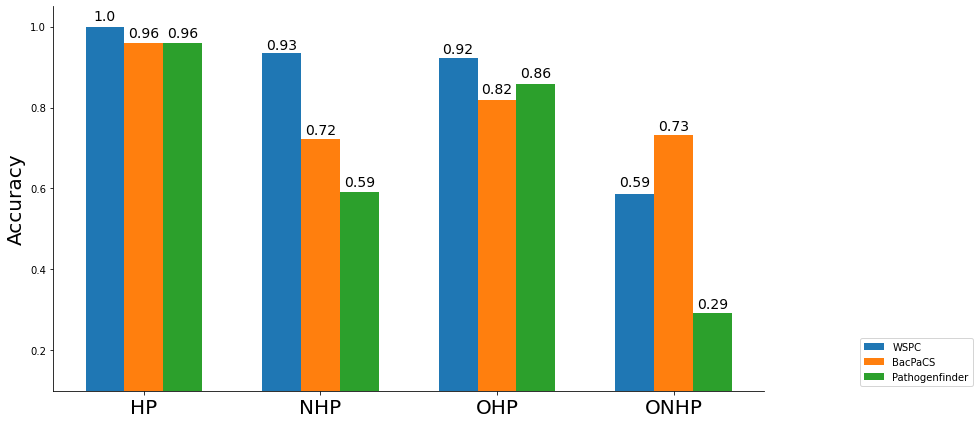

In [222]:
create_comparative_barplots({'WSPC': wspc_results, 'BacPaCS': bacpacs_results, 'Pathogenfinder': pathogenfinder_results})